# HandSegNet Demo

This notebook shows how HandSegNet is used.

In [1]:
import os
import sys
import math

import torch
import torchvision
import torch.nn.functional as F
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc

model_path = os.path.abspath(os.path.join('..'))
if model_path not in sys.path:
    sys.path.append(model_path)
    
from colorhandpose3d.model.HandSegNet import HandSegNet
from colorhandpose3d.utils.general import *

/root/anaconda3/envs/torch041/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/anaconda3/envs/torch041/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/anaconda3/envs/torch041/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/anaconda3/envs/torch041/lib/python3.6/site-packages/ten

## Initialization

Create the model and initialize the weights.

In [2]:
handsegnet = HandSegNet()

## Import weights from Tensorflow model

The original HandSegNet was implemented in Tensorflow. The pre-trained model weights need to be imported.

In [3]:
file_name = '../weights/handsegnet-rhd.pickle'
session = tf.Session()
exclude_var_list = list()
# exclude_var_list = ['HandSegNet/conv5_2/weights', 
#                     'HandSegNet/conv5_2/biases', 
#                     'HandSegNet/conv6_1/weights', 
#                     'HandSegNet/conv6_1/biases']

# read from pickle file
with open(file_name, 'rb') as fi:
    weight_dict = pickle.load(fi)
    weight_dict = {k: v for k, v in weight_dict.items() if not any([x in k for x in exclude_var_list])}
    
keys = [k for k, v in weight_dict.items() if 'HandSegNet' in k]
keys.sort()

# [print(k, weight_dict[k].shape) for k in keys]
    
for name, module in handsegnet.named_children():
    key = 'HandSegNet/{0}/'.format(name)
    if key + 'biases' in weight_dict:
        b = torch.tensor(weight_dict[key + 'biases'])
        w = torch.tensor(weight_dict[key + 'weights'])
        w = w.permute((3, 2, 0, 1))
        w = torch.nn.Parameter(w)
        b = torch.nn.Parameter(b)
        module.weight.data = w
        module.bias.data = b
        
torch.save(handsegnet.state_dict(), '../saved/handsegnet.pth.tar')

## Test HandSegNet on a sample

Now that the pre-trained weights are loaded, test a sample from RHD.

In [4]:
def visualize_mask(img, mask):
    plt.figure(figsize=(16, 16))
    plt.subplot(121)
    plt.imshow(img)
    
    plt.subplot(122)
    plt.imshow(mask)
    plt.show()

tensor([[-4.9912, -4.9912, -4.9912, -4.9912, -5.1213, -5.3815, -5.6417, -5.9019,
         -6.1621, -6.4222],
        [-4.9912, -4.9912, -4.9912, -4.9912, -5.1213, -5.3815, -5.6417, -5.9019,
         -6.1621, -6.4222],
        [-4.9912, -4.9912, -4.9912, -4.9912, -5.1213, -5.3815, -5.6417, -5.9019,
         -6.1621, -6.4222],
        [-4.9912, -4.9912, -4.9912, -4.9912, -5.1213, -5.3815, -5.6417, -5.9019,
         -6.1621, -6.4222],
        [-5.1461, -5.1461, -5.1461, -5.1461, -5.2770, -5.5388, -5.8007, -6.0625,
         -6.3244, -6.5862],
        [-5.4558, -5.4558, -5.4558, -5.4558, -5.5884, -5.8535, -6.1187, -6.3838,
         -6.6490, -6.9141],
        [-5.7655, -5.7655, -5.7655, -5.7655, -5.8997, -6.1682, -6.4367, -6.7051,
         -6.9736, -7.2420],
        [-6.0752, -6.0752, -6.0752, -6.0752, -6.2111, -6.4829, -6.7546, -7.0264,
         -7.2982, -7.5699],
        [-6.3849, -6.3849, -6.3849, -6.3849, -6.5225, -6.7975, -7.0726, -7.3477,
         -7.6228, -7.8979],
        [-6.6946, -

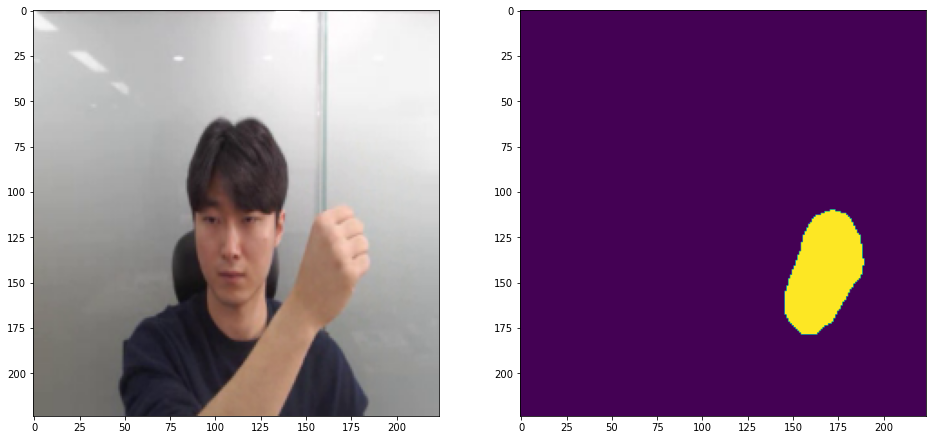

In [9]:
transform0 = torchvision.transforms.ToPILImage()
transform1 = torchvision.transforms.ToTensor()
transform2 = torchvision.transforms.Resize((224, 224))
# img = Image.open('../data/RHD_v1-1/RHD_published_v2/training/color/00008.png')
img = Image.open('../outputs/in_video/0883.png')

sample_original = transform1(transform2(img)).unsqueeze(0)
sample = sample_original - 0.5
output = handsegnet.forward(sample)
mask = output.argmax(1).to(torch.float)
mask_img = transform0(mask.to(torch.float))
print(output[0, 1, :10, :10])

visualize_mask(transform2(img), mask_img)

# Refining the segmentation

The most likely object in the segmentation score map is found uding morphological dilation.

torch.Size([1, 2, 224, 224])
s shape torch.Size([1, 2, 224, 224])
for loop time 1.0817556381225586


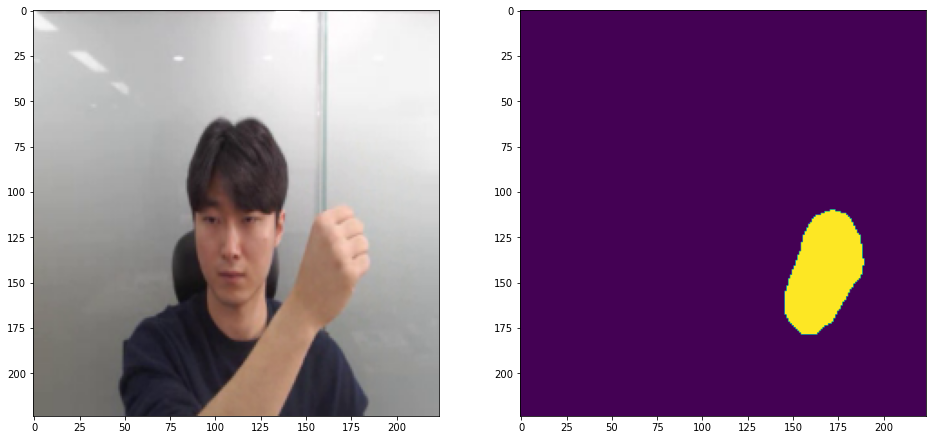

In [10]:
print(output.shape)
hand_mask = single_obj_scoremap(output, 21)
hand_mask_img = transform0(hand_mask[0])
visualize_mask(transform2(img), hand_mask_img)

## Calculate Bounding Box

The final step of the hand segmentation module is to calculate the bounding box and crop the hand from the original image.

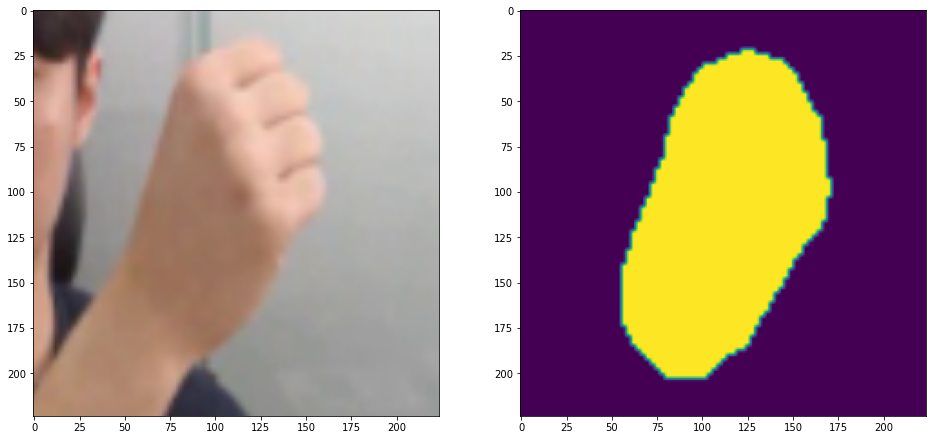

In [11]:
# Test the implementation of calc_center_bb
centers, bbs, crops = calc_center_bb(hand_mask)
crops = crops.to(torch.float32)
crop_size = 224

crops[0] *= 1.25
scale_crop = min(max(crop_size / crops[0], 0.25), 5.0)
image_crop = crop_image_from_xy(sample_original, centers, crop_size, scale_crop)
mask_crop = crop_image_from_xy(hand_mask, centers, crop_size, scale_crop)
img = transform0(image_crop[0])
mask_img = transform0(mask_crop[0])
visualize_mask(img, mask_img)